In [27]:
import requests
import json
import networkx

# import modules from biothings_explorer
from biothings_explorer.hint import Hint
from biothings_explorer.user_query_dispatcher import FindConnection

## Step 1: Find your representations
The first step of the integration is naturally doing all of your stuff. We are going to try to find a BREAST CANCER -- GENE -- DRUG connection and calculate probabilites of survival time greater than a year using real-world TCGA data to rank your proposed connections.

For simplicity of calculation, we are going to fix the drug to explore, i.e. Tamoxifen and focus on the gene. It should also be noted that currently the probabilities are not accurate and should not be taken as actual evidence of a connection. This notebook and our current implementation are only for integration and demostration purposes. 

In [2]:
ht = Hint()
hint = ht.query("tamoxifen")
tamoxifen = hint['ChemicalSubstance'][0]

In [3]:
hint = ht.query('breast cancer')
breast_cancer = hint['Disease'][0]

In [4]:
fc = FindConnection(input_obj=breast_cancer, output_obj=tamoxifen, intermediate_nodes=['Gene'])

In [5]:
fc.connect()

In [6]:
#-- Now we export to Reasoner Std API
reasoner_std = fc.to_reasoner_std()

## Step 2: Add the Probability targets as a top-level property to Reasoner Std
Now we will add some fields to the Reasoner Std dictionary (JSON) to let the CHP what probability targets we want to analyze and return.

In [10]:
reasoner_std['probability_targets'] = [('Survival', '>=', '365')]
reasoner_std['reasoner_id'] = 'explorer'

In [22]:
#-- Now lets package the query and sent it to the CHP API endpoint.
payload = {'query': reasoner_std}
r = requests.post('http://127.0.0.1:8000/submitQuery/', json=payload)

## Step 3: Parse Content and Understand Results
The reponse of the CHP is returned in Reasoner Std API format. The CHP resposne leaves the Query Graph unchanged and decorates the Knowledge Graph with associated probabilties specified in the probability targets, in this case, Survival. Further, the results are recollected to form a complete subgraph of the knowledge graph (i.e. an instantiation of a DISEASE - GENE - DRUG tuple).

However, in the current implementation you must search a little bit for the full decorated result graph. Here we show how to do it. 

In [23]:
chp_resp = json.loads(r.content)

We will extract the first result, i.e. the first node and edge binding along with this new object call probability_target_edges:


In [24]:
node_bindings1 = chp_resp['results']['node_bindings'][0]
edge_bindings1 = chp_resp['results']['edge_bindings'][0]
probability_target_edges = chp_resp['results']['probability_target_edges'][0]

In [25]:
#-- Now get all the edges related to the result
complete_result_edges = set()
#-- First the edges in the edge_bindings.
for _, kedge_ls in result1[1].items():
    complete_result_edges.add(kedge_ls[0])
#-- Next the edges in the probabilty target edges
complete_result_edges.update(probability_target_edges)

### Let's put this all in a NetworkX Graph so we can visualize the result

In [31]:
#-- First let's hash the KG edges and nodes by there IDs
kedges = {edge['id']: edge for edge in chp_resp['knowledge_graph']['edges']}
knodes = {node['id']: node for node in chp_resp['knowledge_graph']['nodes']}

In [32]:
G = networkx.DiGraph()
for edge in complete_result_edges:
    source_node = knodes[kedges[edge]['source_id']]
    target_node = knodes[kedges[edge]['target_id']]
    G.add_node(source_node['id'], attr_dict=source_node)
    G.add_node(target_node['id'], attr_dict=target_node)
    G.add_edge(source_node['id'], target_node['id'])

In [44]:
#-- Extract Labels
labels = {}
for node_info in G.nodes(data=True):
    labels[node_info[0]] = node_info[1]['attr_dict']['name']

{'name:breast cancer': 'BREAST CANCER',
 '8d8e2e4c-e219-4524-a184-4aef7c85bfb2': 'Survival >= 365 = False',
 'name:tamoxifen': 'TAMOXIFEN',
 'SYMBOL:BCAR4': 'BREAST CANCER ANTI-ESTROGEN RESISTANCE 4',
 '36700aea-e6c0-4a6c-9445-0adb9af192a4': 'Survival >= 365 = True'}

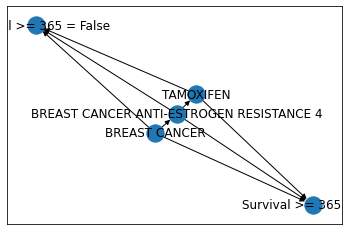

In [46]:
networkx.draw_networkx(G,
                       pos=networkx.spring_layout(G),
                       labels=labels)

In [52]:
#-- Print out associated probabilities
for node_info in G.nodes(data=True):
    if node_info[1]['attr_dict']['type'] == 'probability':
        print('Probability of {} is {}'.format(node_info[1]['attr_dict']['name'],
                                               node_info[1]['attr_dict']['node_attributes'][0]['value']))

Probability of Survival >= 365 = False is 0.1501437755430285
Probability of Survival >= 365 = True is 0.25750915247627804
